1. Imports & Global Settings

cv2 → OpenCV library for image/video processing and deep learning inference.

numpy → For numerical operations and array manipulation.

time → To measure inference time (for FPS calculation).

psutil → To monitor system memory usage during inference.

os → For file path handling and existence checks.

urllib.request → To download coco.names if not found locally.

In [1]:
import cv2
import numpy as np
import time
import psutil
import os
import urllib.request
from IPython.display import display, clear_output
import PIL.Image

2. Confiuration of path & Global settings

In [2]:
# Paths & Settings

MODEL_PATH = "/home/kukil/yolo_detection/yolov8n.onnx"
VIDEO_PATH = "/home/kukil/yolo_detection/video.mp4"   
NAMES_PATH = "/home/kukil/yolo_detection/coco.names"

# Display settings 
INPUT_SIZE = 640
DISPLAY_WIDTH  = 1280
DISPLAY_HEIGHT = 720

3. Load the ONNX Model

In [3]:
net = cv2.dnn.readNet(MODEL_PATH)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
print("Using CPU for inference")

Using CPU for inference


4. Load or Download coco.names

In [4]:
# Robust coco.names download and load
# Check if coco.names file exists
if not os.path.exists(NAMES_PATH):
    print("coco.names not found. Downloading from Ultralytics...")
    
    # URL to download the official coco.names file
    url = "https://raw.githubusercontent.com/ultralytics/xview-yolov3/master/data/coco.names"
    
    try:
        # Download the file from the URL and save it locally
        urllib.request.urlretrieve(url, NAMES_PATH)
        print(f"Downloaded: {NAMES_PATH}")
    except Exception as e:
        # Exit if download fails
        print(f"Failed to download coco.names: {e}")
        exit(1)

# Load class names from coco.names
with open(NAMES_PATH, "r") as f:
    # Read each line, strip whitespace, ignore empty lines
    CLASS_NAMES = [line.strip() for line in f.readlines() if line.strip()]

# Verify classes loaded
print(f"Loaded {len(CLASS_NAMES)} class names")  # Print total classes (should be 80)

# Safety check
if len(CLASS_NAMES) == 0:
    # Exit if file is empty or corrupted
    print("ERROR: CLASS_NAMES is empty! Check coco.names file.")
    exit(1)
else:
    # Show sample of first 5 classes
    print("Sample classes:", CLASS_NAMES[:5])


Loaded 80 class names
Sample classes: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane']


5. Pre-processing – Letterbox

This function is a key preprocessing step for YOLO models, it resizes and pads the image to the correct input size (640×640) without distorting its aspect ratio.

In [5]:
# Letterbox helper
def letterbox(img, new_shape=(640, 640), color=(114, 114, 114)):

    #Get the original image height and width
    h, w = img.shape[:2]

    #Scale ratio (new/old), keeping the aspect ratio
    r = min(new_shape[0] / h, new_shape[1] / w)

    #calculate the new image size after scaling
    new_unpad = (int(round(w * r)), int(round(h * r)))

    #compute how much padding is needed to reach target shape
    dw = (new_shape[1] - new_unpad[0]) / 2       #padding to add on the left/right
    dh = (new_shape[0] - new_unpad[1]) / 2       #padding to add on the top/bottom

    #resize image
    img_resized = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)

    #calculate border sizes (top, bottom, left, right)
    top = int(round(dh))
    bottom = int(round(dh))
    left = int(round(dw))
    right = int(round(dw))

    #add border (padding) with given color
    img_padded = cv2.copyMakeBorder(
        img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )
    return img_padded, r, (dw, dh)

6. Normalize YOLO Output Tensor

When you run YOLOv8 in OpenCV DNN (net.forward()), the output shape can differ:
- Some exports return [1, N, 85]
- Others [1, 85, N]
- Or even squeezed versions [N, 85] / [85, N]

This function normalizes all of those into a consistent 2D array of shape:

(number_of_detections, 85)
    
where 85 = 4 (bbox) + 1 (objectness) + 80 (class scores)

In [6]:
def normalize_output_tensor(outs):
    arr = outs[0]  # Take the first (and usually only) output tensor from OpenCV DNN

    # CASE 1: check if it's a 3D tensor (e.g. shape [1, N, 85] or [1, 85, N]) 
    if arr.ndim == 3:
        a, b, c = arr.shape  # extract dimensions
        # Example: shape [1, N, 85] → remove batch dim and return [N, 85]
        if a == 1 and c in (84, 85):
            return arr[0]
        # Example: shape [1, 85, N] → transpose to [N, 85]
        if a == 1 and b in (84, 85):
            return arr[0].T

    # CASE 2: check if it's a 2D tensor (e.g. [N, 85] or [85, N]) 
    if arr.ndim == 2:
        # Correct orientation: columns = 85 → return as-is
        if arr.shape[1] in (84, 85):
            return arr
        # Transposed orientation: rows = 85 → transpose it
        if arr.shape[0] in (84, 85):
            return arr.T

    # CASE 3: Squeezed output (remove redundant dimensions) 
    sq = np.squeeze(outs)  # removes dimensions of size 1, e.g. [1, N, 85] → [N, 85]

    # If shape still looks valid after squeezing, handle similarly:
    if sq.ndim == 2 and sq.shape[1] in (84, 85):
        return sq
    if sq.ndim == 2 and sq.shape[0] in (84, 85):
        return sq.T

    # CASE 4: Unsupported / unknown shape 
    raise ValueError(f"Unsupported output shape: {outs.shape}")


7. Sigmoid Helper

The sigmoid (or logistic) function converts any real number into a value between 0 and 1.
It’s commonly used to turn raw outputs (logits) into probabilities.

YOLO models often apply the sigmoid to:
- objectness score (how likely an object exists in the box)
- class scores (how likely each class is present)

In [7]:
def sigmoid(x):
    # Limit 'x' values to the range [-50, 50] to avoid overflow in exp(-x)
    x = np.clip(x, -50, 50)

    # Apply the sigmoid formula: sigmoid(x) = 1 / (1 + exp(-x))
    # Converts any real number → (0, 1) range
    return 1.0 / (1.0 + np.exp(-x))


8. Post processing detection loop

Main function of the YOLOv8 detection pipeline. It takes a single frame, preprocesses it, runs inference, parses detections, filters them, and finally draws bounding boxes and labels on the image.

In [8]:
# Main detection function 
def detect_objects(frame, conf_thresh=0.20, iou_thresh=0.45):

    #1. basic setup
    H, W = frame.shape[:2]     #get the original image height, width
    orig_frame = frame.copy()  

    
    # 2. Preprocessing(resize and blob)
    #resize + pad image to 640x640 while keeping the aspect ratio
    lb_img, ratio, (dw, dh) = letterbox(frame, (INPUT_SIZE, INPUT_SIZE))
    #convert image to blob format for opencv DNN
    blob = cv2.dnn.blobFromImage(lb_img, 1/255.0, (INPUT_SIZE, INPUT_SIZE), swapRB=True, crop=False)
    #set the blob as network input
    net.setInput(blob)

    
    # 3. Model Inference
    proc = psutil.Process()       
    mem_before = proc.memory_info().rss / (1024**2)    #memory before inference
    t0 = time.time()                                   #start time
    
    outs = net.forward()                               #run model inference
    
    t1 = time.time()                                   #end time
    mem_after = proc.memory_info().rss / (1024**2)     #memory after inference

    
    # 4. Normalize model output shape
    dets = normalize_output_tensor(outs)               #ensure conistent shape [N,85]
    N, C = dets.shape                                  # N = detections, C = 85 (x,y,w,h,obj + classes)

    
    # 5. Detect if sigmoid/scale needed
    #some ONNX reports have raw logits instead of probabilties
    need_sigmoid = False
    if N > 0:
        cls_part = dets[:50, 5:] if C == 85 else dets[:50, 4:]
        # If values are not between [0,1], they’re logits → need sigmoid
        if np.max(cls_part) > 1.5 or np.min(cls_part) < -0.5:
            need_sigmoid = True

    # Check if coordinates are normalized (0–1) or pixel-scaled
    need_scale = False
    if N > 0:
        median_wh = np.median(dets[:50, 2:4], axis=0)
        # If box sizes are too small (<2), assume they’re normalized → need scaling
        need_scale = np.max(median_wh) < 2.0

    # 6. Initialize lists for final detection
    boxes, scores, class_ids = [], [], []
    has_obj = (C == 85)                  #True if model has objectness score

    # 7. loop through each detection row
    for d in dets:
        if has_obj:
            # YOLO format: [x, y, w, h, obj_conf, class_probs...]
            obj = d[4]                      # objectness confidence
            cls_scores = d[5:]              # class confidence scores

            # apply sigmoid if raw outputs are unnormalized
            if need_sigmoid:                 
                obj = sigmoid(obj)
                cls_scores = sigmoid(cls_scores)
            #pick the best class prediction
            cls_id = int(np.argmax(cls_scores))
            cls_conf = float(cls_scores[cls_id])

            # final confidence = objectness * class confidence
            score = float(obj * cls_conf)
        else:
            # for models without objectness
            cls_scores = d[4:]
            if need_sigmoid:
                cls_scores = sigmoid(cls_scores)
            cls_id = int(np.argmax(cls_scores))
            score = float(cls_scores[cls_id])

        #skip weak detections below confidence threshold
        if score < conf_thresh:
            continue

        # 8. Extract and rescale bounding box
        cx, cy, w, h = d[0:4]
        # Scale boxes if coordinates are normalized (0–1)
        if need_scale:
            cx *= INPUT_SIZE; cy *= INPUT_SIZE; w *= INPUT_SIZE; h *= INPUT_SIZE

        # Convert from center format → top-left/bottom-right corners
        x1 = (cx - w/2 - dw) / ratio
        y1 = (cy - h/2 - dh) / ratio
        x2 = (cx + w/2 - dw) / ratio
        y2 = (cy + h/2 - dh) / ratio

        # clamp box within image boundaries
        x1 = max(0, min(W-1, int(x1)))
        y1 = max(0, min(H-1, int(y1)))
        x2 = max(0, min(W-1, int(x2)))
        y2 = max(0, min(H-1, int(y2)))

        #skip invalid boxes
        if x2 <= x1 or y2 <= y1:
            continue
            
        #save detection
        boxes.append([x1, y1, x2 - x1, y2 - y1])
        scores.append(score)
        class_ids.append(cls_id)

    # 9. apply Non-Maximum Suppression(NMS)
    indices = cv2.dnn.NMSBoxes(boxes, scores, conf_thresh, iou_thresh)
    idx_list = indices.flatten().tolist() if len(indices) > 0 else []

    # 10. Draw bounding boxes & labels
    for i in idx_list:
        x, y, w, h = boxes[i]
        cls = class_ids[i]
        score = scores[i]

        #get class name or fall back to unknown
        name = CLASS_NAMES[cls] if 0 <= cls < len(CLASS_NAMES) else f"unknown:{cls}"
        label = f"{name} {score:.2f}"

        #draw rectangle on the original image
        cv2.rectangle(orig_frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label_y = max(20, y - 10)

        #draw label text above the box
        cv2.putText(orig_frame, label, (x, label_y),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # 11. Print and display performance ratio
    inference_time = t1 - t0
    fps = 1.0 / inference_time if inference_time > 0 else 0
    print(f"Inference: {inference_time:.3f}s | FPS: {fps:.1f} | Mem: {(mem_after - mem_before):.2f} MB")

    # 12. Resize for display
    display_frame = cv2.resize(orig_frame, (DISPLAY_WIDTH, DISPLAY_HEIGHT))

    # Show FPS on screen
    cv2.putText(display_frame, f"FPS: {fps:.1f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    return display_frame


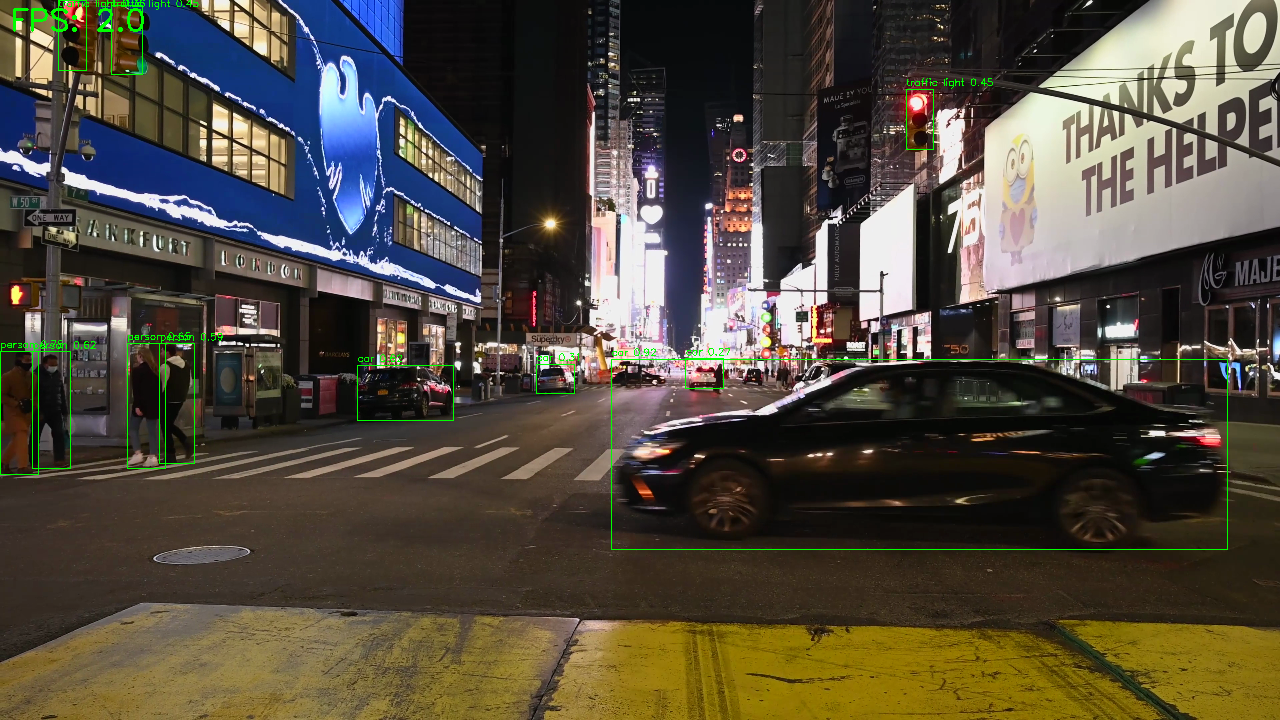

End of video.
Video processing finished.


In [9]:
# Video processing

#open the video file
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print(f"Error: Cannot open video file: {VIDEO_PATH}")
    cap.release()
    raise SystemExit

print(f"Processing video: {VIDEO_PATH}")
print("Press stop (square icon) to end execution")

#frame skipping and counters
frame_skip = 2
counter = 0

# video processing loop
while True:
    ret, frame = cap.read()
    if not ret:
        print("End of video.")
        break

    #run object detection
    result_frame = detect_objects(frame, conf_thresh=0.25, iou_thresh=0.45)

    # display the frame inline
    img_rgb = cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB)
    clear_output(wait=True)
    display(PIL.Image.fromarray(img_rgb))

#release video capture
cap.release()
print("Video processing finished.")